**Time Series Anlaysis - Project 1: SARIMA**

**Model Accuracy: 98.32% (non-rolling), 97.53% (rollling)** <br>
**In this project we will be predicting sales data using the SARIMA model** <br>
**The dataset can be found here: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/catfish.csv**

***Importing Required Modules***

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from time import time
from pmdarima import auto_arima
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

***Formatting the dataset***

In [147]:
catfish_sales = pd.read_csv("/Users/willbarnard/Downloads/catfish.csv", parse_dates=[0], index_col=[0], date_format = '%Y-%m-%d')

In [148]:
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

***Splitting the dataset into training and testing***

In [149]:
start_date = datetime(1996, 1, 1)
end_date = datetime(2000, 1, 1)
lim_catfish_sales = catfish_sales[start_date:end_date]

train_end = datetime(1999,7,1)
test_end = datetime(2000, 1, 1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end:test_end]

***Displaying the dataset***

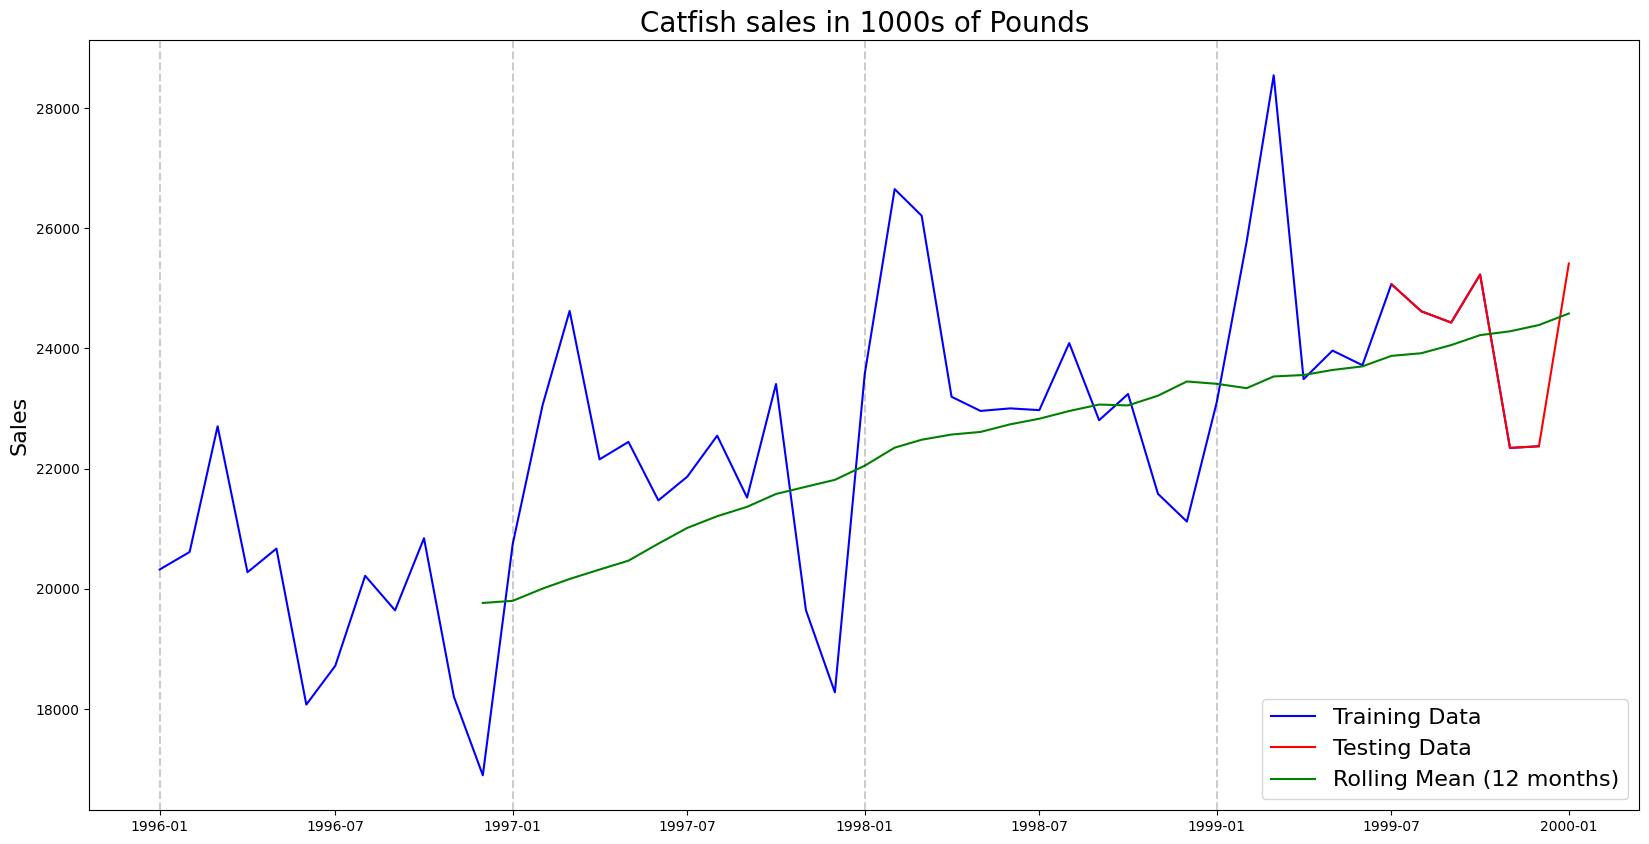

In [179]:
plt.figure(figsize=(20,10))
plt.plot(train_data,color='blue')
plt.plot(test_data,color='red')
plt.plot(lim_catfish_sales.rolling(12).mean(), color='green')
plt.title('Catfish sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend(("Training Data", "Testing Data", "Rolling Mean (12 months)"), fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

**Seasonal decomposition of the dataset**

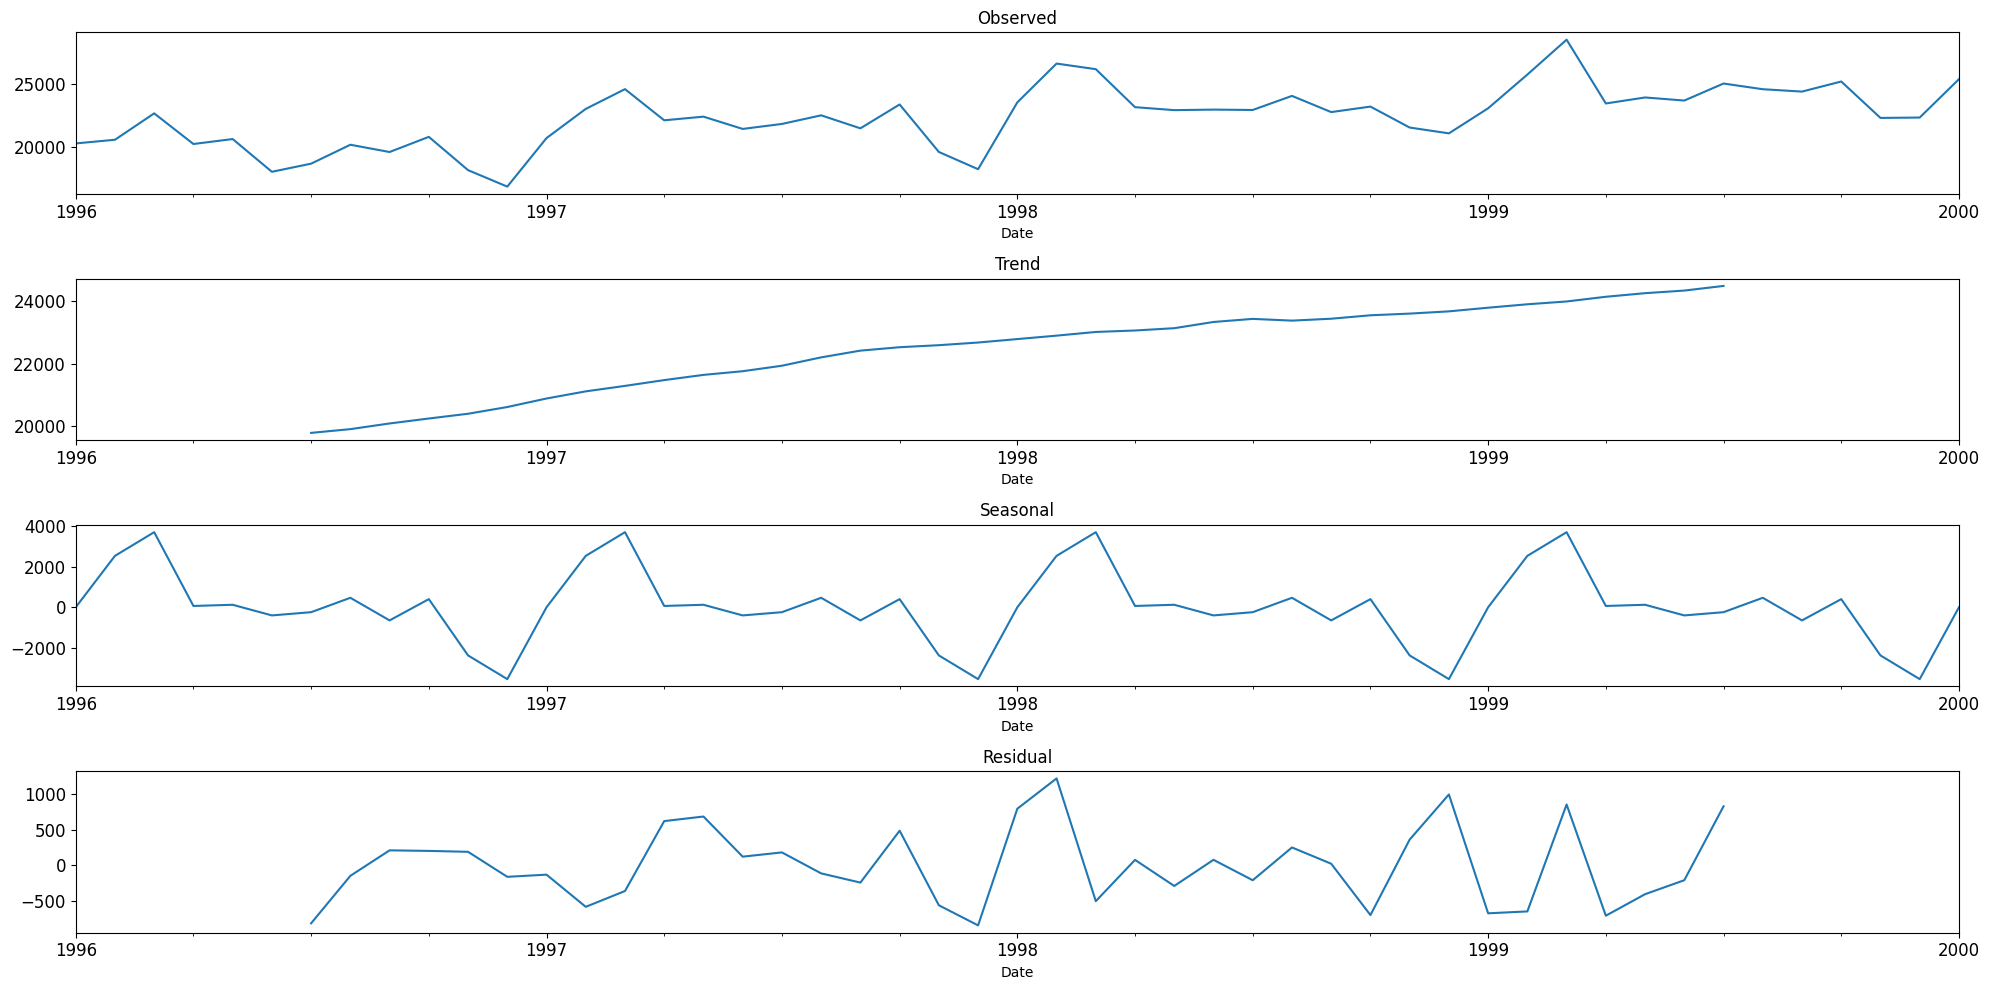

In [151]:
seasonal_decomp = sm.tsa.seasonal_decompose(lim_catfish_sales, period=12)

fig, axes = plt.subplots(4, 1, figsize=(20, 10))  

seasonal_decomp.observed.plot(ax=axes[0], title="Observed", fontsize=12)
seasonal_decomp.trend.plot(ax=axes[1], title="Trend", fontsize=12)
seasonal_decomp.seasonal.plot(ax=axes[2], title="Seasonal", fontsize=12)
seasonal_decomp.resid.plot(ax=axes[3], title="Residual", fontsize=12)

plt.tight_layout()  
plt.show()

**ADF (Augmeneted Dickey-Fuller) test to check for stationary data**

In [152]:
result = adfuller(lim_catfish_sales)

ADFtestStatistic = result[0]
pValue = result[1]
numLags = result[2]
numObservations = result[3]
criticalValues = result[4]

print("ADF Statistic: ", ADFtestStatistic)
print("p-value: ", pValue)
print("Number of lags: ", numLags)
print("Number of observations: ", numObservations)
print("Critical values: ", criticalValues)

if pValue <= 0.05:
    print("The series is likely stationary (reject null hypothesis). ")
else:
    print("The series is likely non-stationary (fail to reject null hypothesis).")

ADF Statistic:  -2.342716373908364
p-value:  0.15856082643054054
Number of lags:  11
Number of observations:  37
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
The series is likely non-stationary (fail to reject null hypothesis).


***Removing the trend through differencing***

In [153]:
first_diff = lim_catfish_sales.diff()[1:]

***Displaying the differenced data***

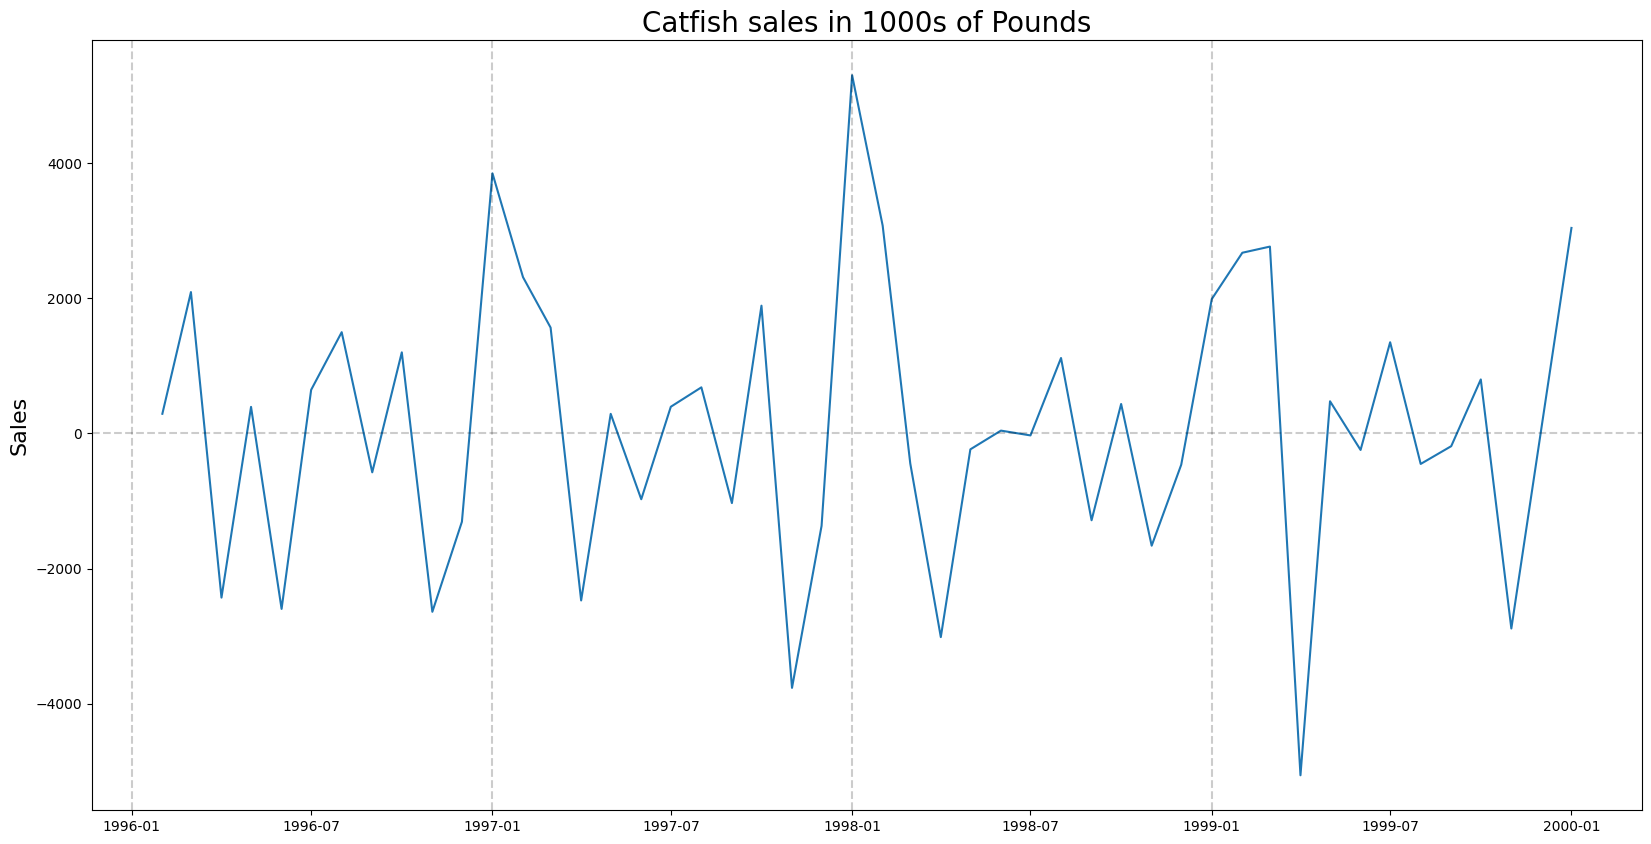

In [154]:
plt.figure(figsize=(20,10))
plt.plot(first_diff)
plt.title('Catfish sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)


***Calculating and displaying ACF (autocorrelation function)***

<BarContainer object of 17 artists>

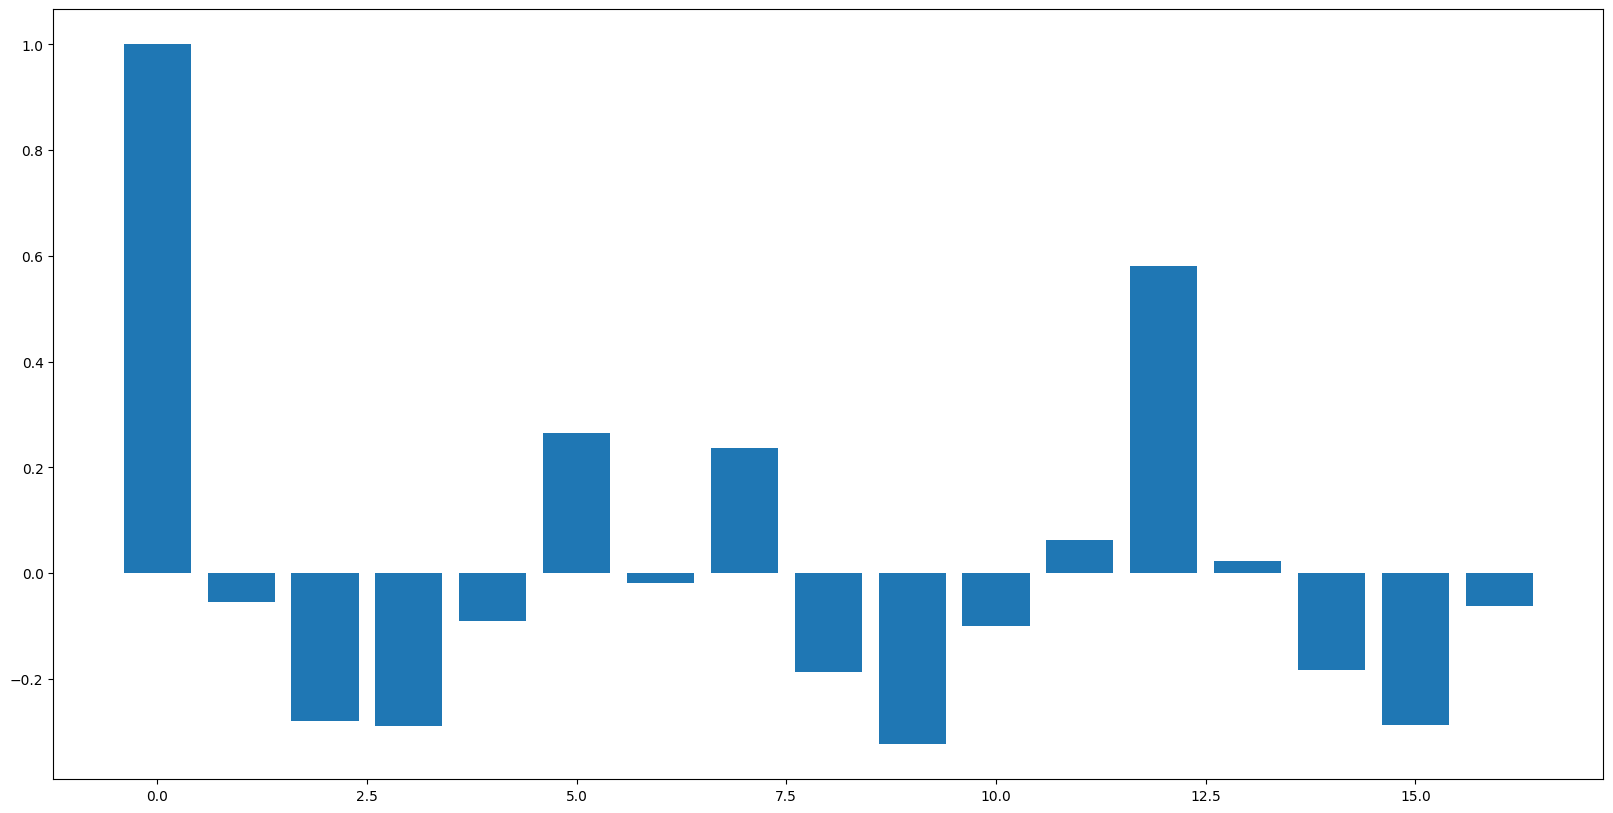

In [155]:
acf_vals = acf(first_diff)
plt.figure(figsize=(20,10))
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])

***Calculating and displaying PACF (Partial Autocorrelation Function)***

<BarContainer object of 17 artists>

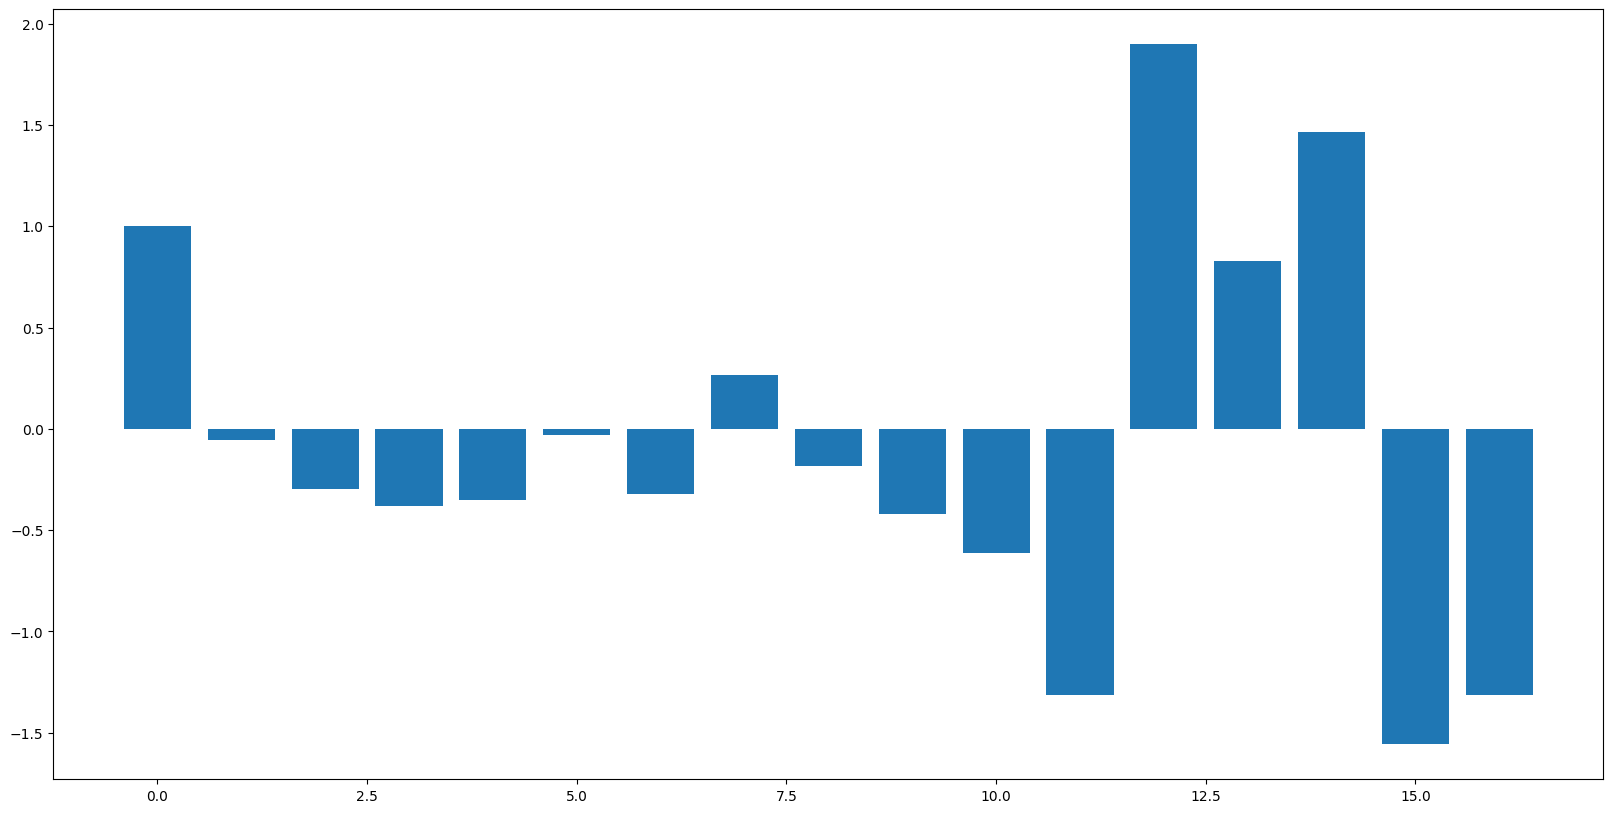

In [156]:
pacf_vals = pacf(first_diff)
plt.figure(figsize=(20,10))
num_lags=17
plt.bar(range(num_lags), pacf_vals[:num_lags])

***Recalculating ADF to ensure stationary data***

In [157]:
result = adfuller(first_diff)

ADFtestStatistic = result[0]
pValue = result[1]
numLags = result[2]
numObservations = result[3]
criticalValues = result[4]

print("ADF Statistic: ", ADFtestStatistic)
print("p-value: ", pValue)
print("Number of lags: ", numLags)
print("Number of observations: ", numObservations)
print("Critical values: ", criticalValues)

if pValue <= 0.05:
    print("The series is likely stationary (reject null hypothesis). ")
else:
    print("The series is likely non-stationary (fail to reject null hypothesis).")

ADF Statistic:  -9.515038694170045
p-value:  3.173838700626354e-16
Number of lags:  10
Number of observations:  37
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
The series is likely stationary (reject null hypothesis). 


***Parameter selection: graphical observations***

In [158]:
my_order = (0, 1, 0)
my_seasonal_order = (1, 0, 1, 12)

***Parameter selection: AutoArima search***

In [ ]:
auto_model = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True)
auto_model.summary()
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order
print(p, d, q, P, D, Q, s)

***Define the SARIMA Model***

In [160]:
model = SARIMAX(train_data, order=(0,1,1), seasonal_order=(1, 1, 0, 12))

***Fit the Model***

In [161]:
start = time()
model_fit = model.fit(disp=0)
end = time()
print('Model Fitting Time: ', end - start)
model_fit.summary()

Model Fitting Time:  0.08655309677124023


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -251.213
Date:                             Sun, 09 Mar 2025   AIC                            508.427
Time:                                     13:54:50   BIC                            512.630
Sample:                                 01-01-1996   HQIC                           509.772
                                      - 07-01-1999                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5562      0.124     -4.483      0.000      -0.799      -0.313
ar.S.L12      -0.2886      0.157     -1.841      0.066      -0.596       0.019
sigma2      8.795e+05   3.24e+05      2.713      0.007    2.44e+05    1.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.41   Prob(JB):                         0.55
Heteroskedasticity (H):               3.18   Skew:                             0.28
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***Calculate predictions***

In [162]:
predictions = model_fit.forecast(len(test_data))
test_data_series = test_data['Total']
predictions = pd.Series(predictions, index=test_data_series.index)



**Calculating residuals**

In [163]:
residuals = test_data_series - predictions

***Displaying residuals***

Text(0, 0.5, 'Error')

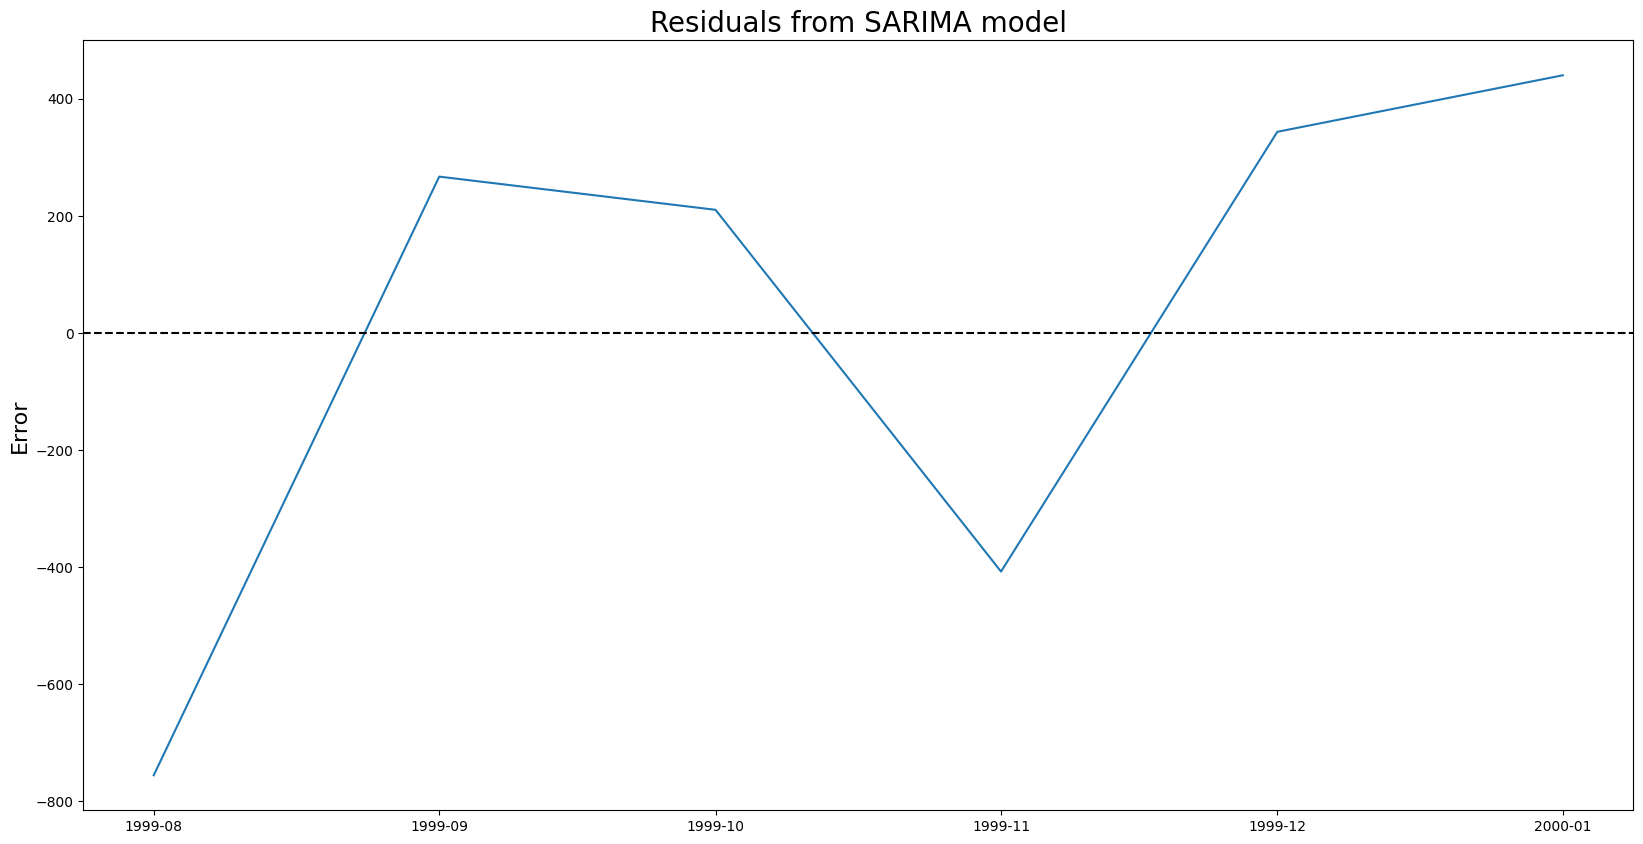

In [164]:
plt.figure(figsize=(20,10))
plt.plot(residuals)
plt.axhline(0, linestyle = '--', color='k')
plt.title('Residuals from SARIMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)

***Displaying predictions***

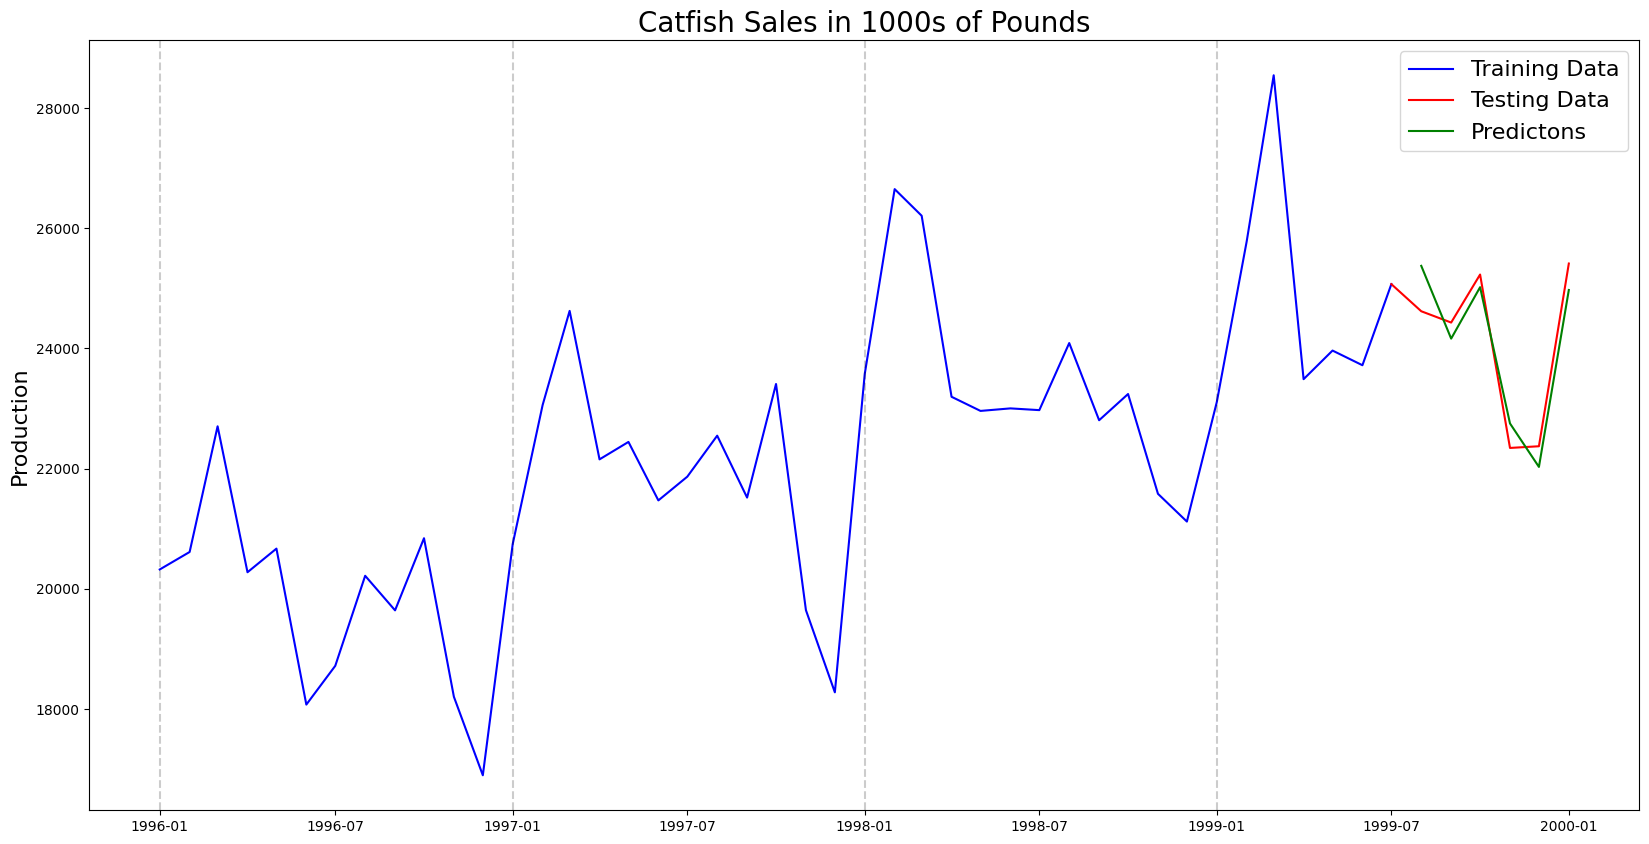

In [165]:
plt.figure(figsize=(20,10))

plt.plot(train_data,color='blue')
plt.plot(test_data,color='red')
plt.plot(predictions, color='green')

plt.legend(('Training Data', 'Testing Data', 'Predictons'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)

***Error metric: MAPE***

In [166]:
print('Mean Absolute Percent error: ', round(np.mean(abs(residuals/test_data_series)), 4))

Mean Absolute Percent error:  0.0168


***Error metric: RMSE***

In [167]:
print('Root Mean Squarred Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Squarred Error:  440.56152301148734


***Calculating rolling forecasts***

In [168]:
rolling_predictions = test_data_series.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12))
    model_fit = model.fit(disp=0)

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/var/folders/2v/t8ll2w9151nf9h3myq7ks4xh0000gn/T/ipykernel_33619/3198413157.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[23834.82401913]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
/var/folders/2v/t8ll2w9151nf9h3myq7ks4xh0000gn/T/ipykernel_33619/3198413157.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/var/folders/2v/t8ll2w9151nf9h3myq7ks4xh0000gn/T/ipykernel_33619/3198413157.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/var/folders/2v/t8ll2w9151nf9h3myq7ks4xh0000gn/T/ipykernel_33619/3198413157.py:8: FutureWarning: Calling float on a single el

***Calcuating Rolling residuals***

In [169]:
rolling_residuals = test_data_series - rolling_predictions

***Displaying rolling residuals***

Text(0, 0.5, 'Error')

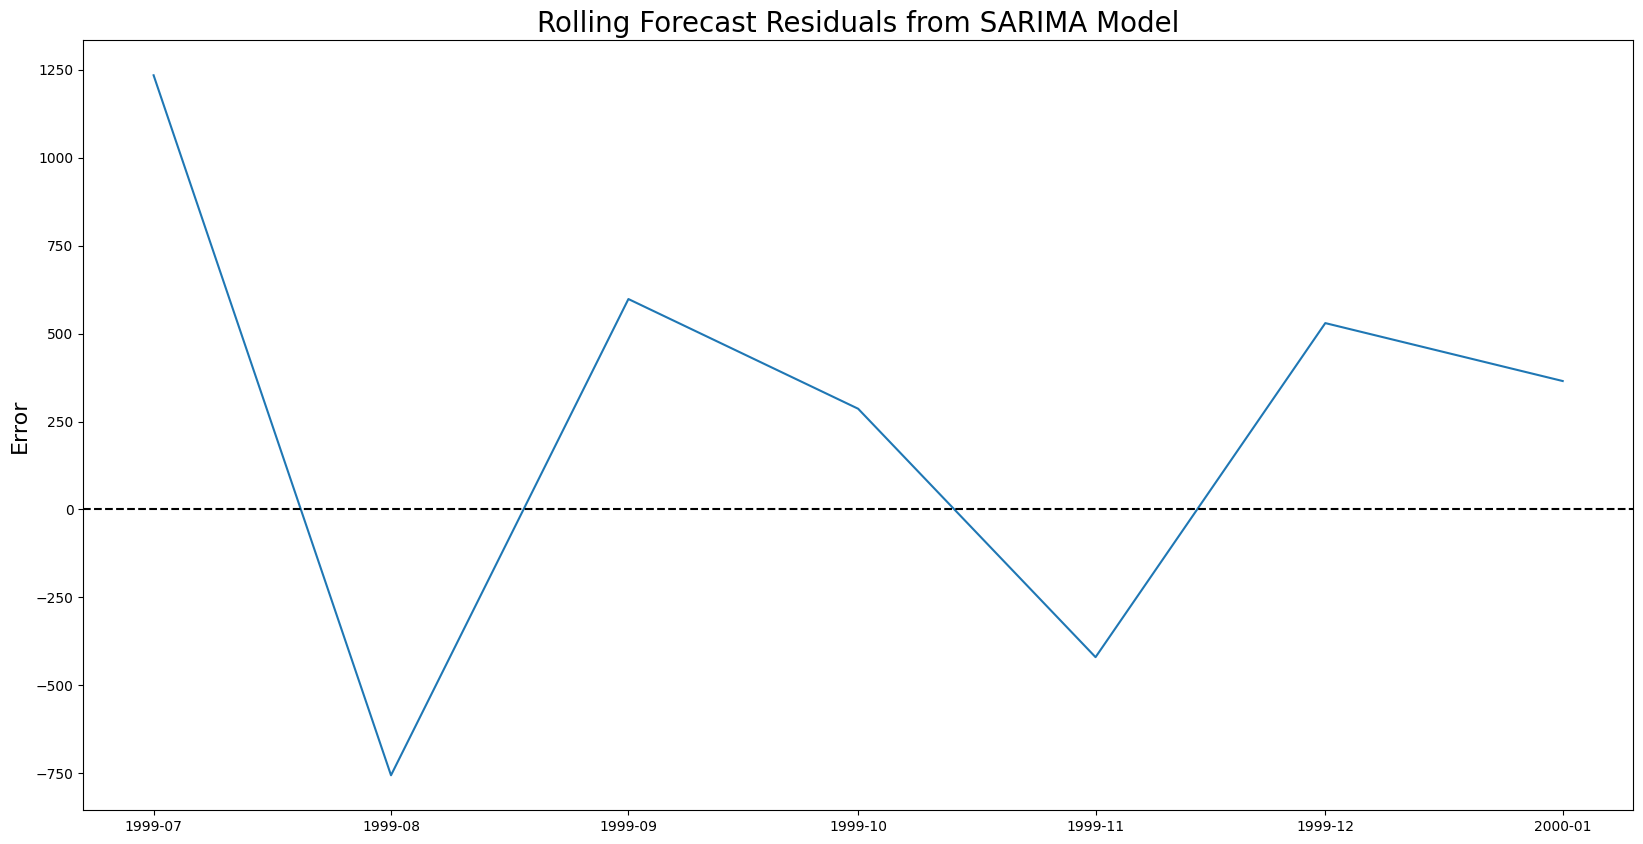

In [170]:
plt.figure(figsize=(20,10))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

***Displaying rolling predictions***

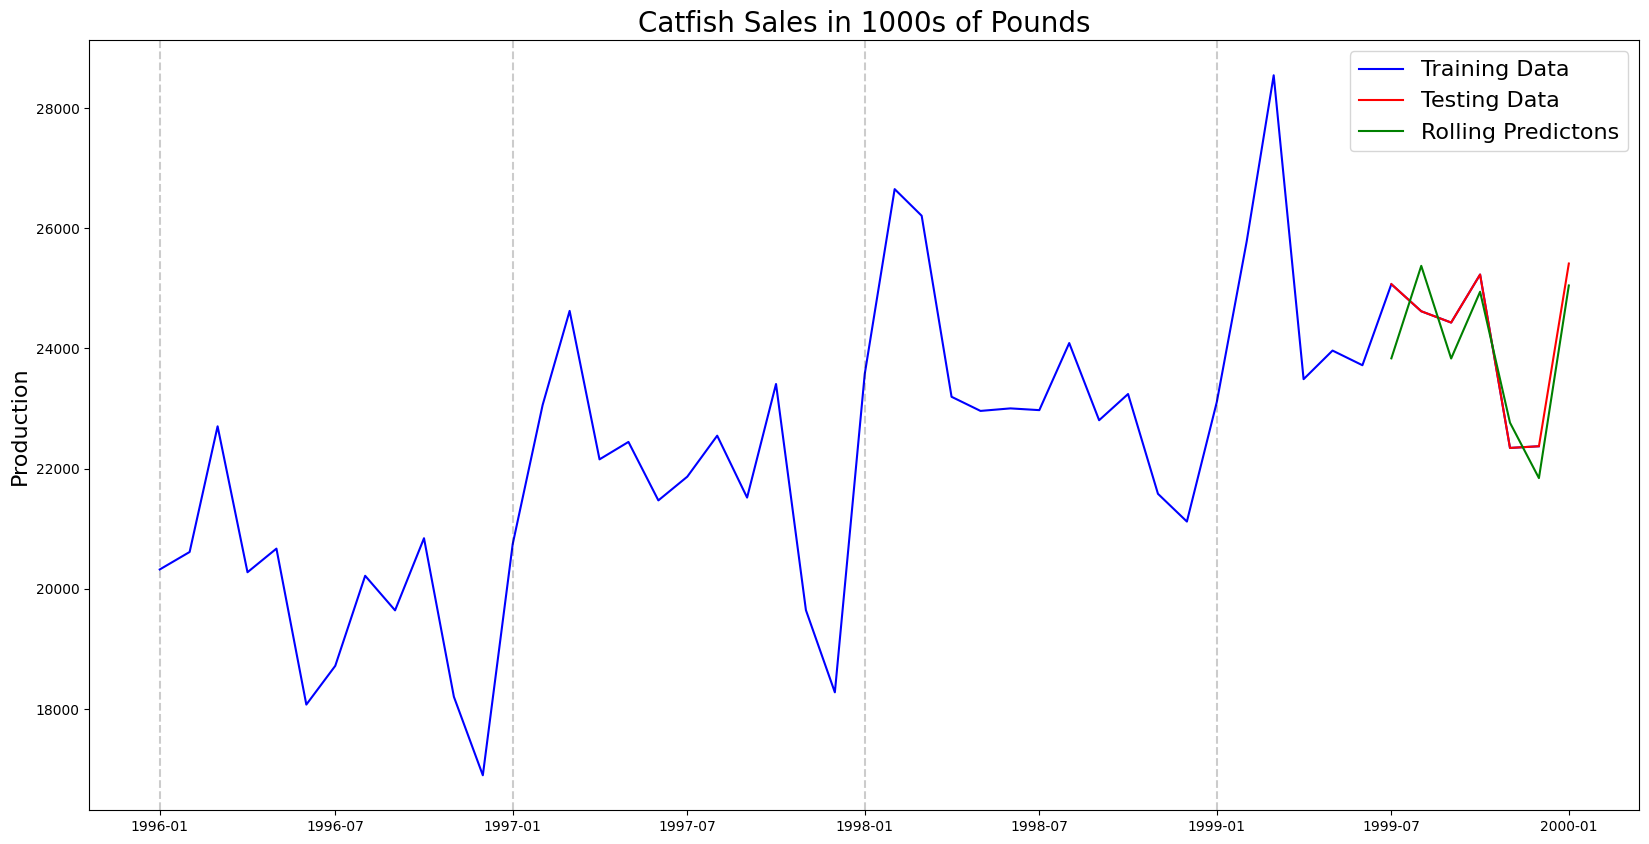

In [171]:
plt.figure(figsize=(20,10))
plt.plot(train_data,color='blue')
plt.plot(test_data,color='red')
plt.plot(rolling_predictions, color='green')

plt.legend(('Training Data', 'Testing Data', 'Rolling Predictons'), fontsize=16)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year) +  '-01-01'), color='k', linestyle='--', alpha=0.2)

***Error metric: MAPE***

In [172]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(rolling_residuals/test_data_series)), 4))

Mean Absolute Percent Error:  0.0247


***Error metric: RMSE***

In [173]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error:  668.0333785386331
